#### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps 
from utils.print_utils import *
from utils.model_utils import *
from utils.interpol_utils import *
from utils.optimization_utils import *
from utils.data_utils import *


#### Synthetic Option

In [2]:
# Constants
r_ = 0.05
sigma_ = 0.4
K_ = 100
T_ = 1.

timesteps = 110
spacesteps =  80

# Monte Carlo simulation
x = np.linspace(.1, K_*3, spacesteps)
t = np.linspace(0.01, T_, timesteps)

dt = t[1] - t[0]
dx = x[1] - x[0]

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

# Calculate 'tal' using vectorized operations
tal = (np.max(t) - T)

# Calculate the call prices using vectorized operations
call_prices = black_scholes(X, K_, tal, r_, sigma_)

# u is the call_prices array
u = call_prices.T

u_t_ = black_scholes_theta(X, K_, tal, r_, sigma_).T[:,:-1]
u_x_ = black_scholes_delta(X, K_, tal, r_, sigma_)
u_xx_ = black_scholes_gamma(X, K_, tal, r_, sigma_)


d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:93: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:76: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:78: RuntimeWarning: invalid value encountered in divide
  theta = -sigma * S * norm.pdf(d1) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:83: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:88: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_ut

Error for Finite Difference 
RSE 0.000885878243209608
RMSE 0.14121739423768026


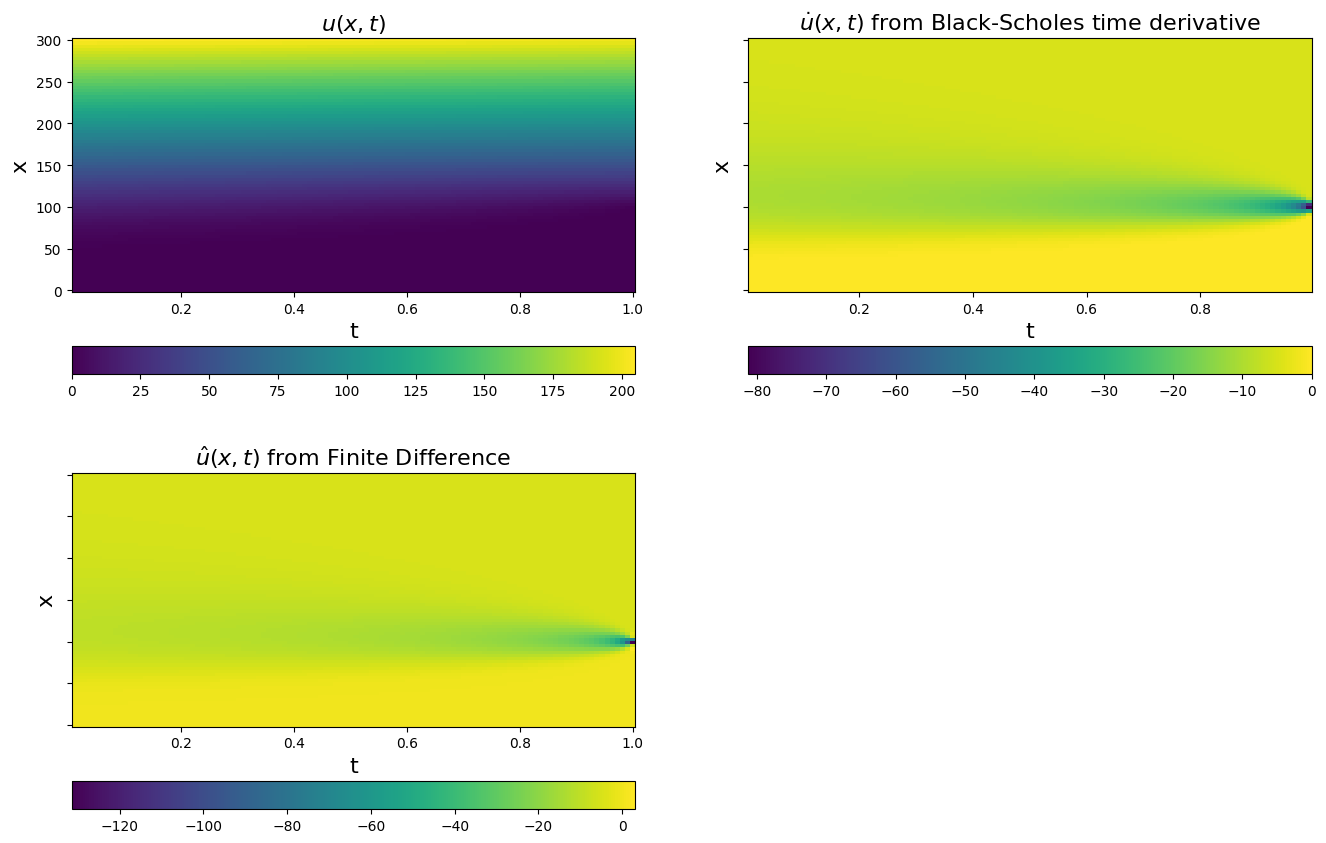

In [3]:
# n_arr = np.asarray([np.arange(0,spacesteps,1)]*timesteps).T
u_x = ps.FiniteDifference(order=12,d=1,axis=0)._differentiate(u,dx)
u_xx = ps.FiniteDifference(order=6,d=2,axis=0)._differentiate(u,dx)
u_t =ps.FiniteDifference(order=2,d=1,axis=1)._differentiate(u,dt)
# v_dot = numerical_partial_black_scholes(u.T,r,sigma).T


# Plot u and u_dot
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
plt.colorbar(orientation="horizontal")

plt.subplot(3, 2, 3)
plt.pcolormesh(t, x, u_t)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\hat{u}(x, t)$ from Finite Difference", fontsize=16)
plt.colorbar(orientation="horizontal")

plt.subplot(3, 2, 2)
plt.pcolormesh(t[:-1], x, u_t_)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from Black-Scholes time derivative", fontsize=16)
plt.colorbar(orientation="horizontal")


# print('Error for DURA-MOS¸NEAGU Computation')
# print('RSE',np.sum((u_t - v_dot)**2)/np.sum((u_t - u_t.mean())**2))
# print('RMSE',(np.sqrt(np.sum((u_t - v_dot)**2).mean())))
print('Error for Finite Difference ')
print('RSE',relative_squared_error(u_t_,u_t[:,:-1]))
print('RMSE',root_mean_squared_error(u_t_,u_t[:,:-1]))

plt.show()

In [4]:
print(relative_squared_error(u_xx.T[:-1],u_xx_[:-1]),
root_mean_squared_error(u_xx.T[:-1],u_xx_[:-1]))

6.690382931563933e-06 1.5399650491659282e-05


In [5]:
print(relative_squared_error(u_x.T[:-1],u_x_[:-1]),
root_mean_squared_error(u_x.T[:-1],u_x_[:-1]))

3.53108415528298e-08 7.800914929785234e-05


##### PySINDy

In [13]:
u_reshaped = np.reshape(u, (len(x), len(t), 1))
u_t  = np.reshape(u_t, (*u_t.shape, 1))

# v_dot  = np.reshape(v_dot, (len(x), len(t), 1))
spatial_grid = np.reshape(X.T, (*X.T.shape, 1))

library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = False,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
    periodic=True # uniformly sampled in time
)

#Create Library with partial derivatives and spatial variable plus cross-terms
u_final = pde_lib.fit_transform(u_reshaped)
u_final = np.concatenate((u_final,spatial_grid,spatial_grid**2),axis=2)
dic_var = {'x0':'u','x1':'u_x', 'x2':'u_{xx}','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]
lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
lib_tr = lib.fit_transform(u_final)

In [26]:
# Add boundary conditional on T time of the derivative
# Create a new shape by adding 1 to the second dimension
original_shape = u_t.shape
new_shape = list(original_shape)
new_shape[1] += 1

_u_t = np.zeros(new_shape)
# Copy the original data into the new array up to the last layer

_u_t[:, :original_shape[1], :] = u_t



print('----------------------------Finite Difference--------------------------------')
#Fit the data using the finite difference approximation

print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=5e-3, alpha=1e5)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final,x_dot = u_t)
# print(model.score(u_test))
model.print()
print('Error Model prediction against analytical solution:')
pred = lib_tr[:,:-1,:] @ model.coefficients()[0]
# print('R2',model.score(x = u_final,x_dot = _u_t))
print('RSE',relative_squared_error(pred.flatten(), u_t_.flatten()))
print('RMSE',root_mean_squared_error(pred.flatten() , u_t_.flatten()))

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(lib_tr,model.coefficients()[0],threshold = 0.01,axis=2,target = u_t)
pred = lib_tr[:,:-1,:] @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',relative_squared_error(pred.flatten(), u_t_.flatten()))
print('RMSE',root_mean_squared_error(pred.flatten() , u_t_.flatten()))

print('*'*50)

----------------------------Finite Difference--------------------------------
STLSQ Regression
(x0)' = 0.048 u*u_x + -0.049 u_x*x + -0.079 u_{xx}*x^2
Error Model prediction against analytical solution:
RSE 0.000693839355725761
RMSE 0.1239681968622437

Mean threshold remove 

u_t = + 0.05 u*u_x + -0.05 u_x*x + -0.08 u_{xx}*x^2
Error Model prediction against analytical solution:
RSE 0.000693839355725761
RMSE 0.1239681968622437
**************************************************


In [37]:
relative_squared_error(lib_tr[:,:,0],lib_tr[:,:,5])

AxesArray(0.00116473)

In [29]:
print('----------------------------Weak Formulation--------------------------------')


library_functions = [lambda x: x, lambda x: x * x,lambda x: X.T,lambda x: X.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']


pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    periodic=False,
    p = 8,
    differentiation_method = ps.FiniteDifference,
    K=500,
)

optimizer = ps.STLSQ(threshold=5e-3, alpha=1e4)

model = ps.SINDy(feature_names = ['u'],feature_library=pde_lib, optimizer=optimizer)
model.fit(u_reshaped)
model.print()
lib_weak = np.concatenate((lib_tr[:,:,:7],lib_tr[:,:,8:]),axis=2)
pred = lib_weak @ model.coefficients()[0]


----------------------------Weak Formulation--------------------------------
(u)' = 0.047 uu_1 + -0.048 xu_1 + -0.080 x**2u_11


In [10]:

print('----------------------------Ensemble method----------------------------')
optimizer = ps.STLSQ(threshold=1e-3, alpha=2e2)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l1')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final, x_dot = u_t,
        library_ensemble =False,
        ensemble = True,
        n_candidates_to_drop=5,
        n_models = 300,
        n_subset = len(t) //2,
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print('Mean:')
print_model(mean_ensemble,lib.get_feature_names(),precision=3)
print('Median:')
print_model(median_ensemble,lib.get_feature_names(),precision=3)
#Fit the data using ensemble methos on the finite difference values

optimizer.coef_ = median_ensemble
pred = lib_tr @ median_ensemble

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(lib_tr,median_ensemble,target = u_t,threshold = 0.05,axis=2)
pred = lib_tr[:,:-1,:] @ new_coef
print_model(new_coef,lib.get_feature_names())


----------------------------Ensemble method----------------------------
Mean:
u_t = + 0.013 u + -0.0 u_x + -0.0 x + -0.0 x^2 + 0.034 u*u_x + -0.0 u*u_{xx} + 0.0 u*x + -0.047 u_x*x + 0.0 u_{xx}*x + -0.079 u_{xx}*x^2
Median:
u_t = + 0.014 u + 0.035 u*u_x + -0.049 u_x*x + -0.079 u_{xx}*x^2

Mean threshold remove 

u_t = + 0.03 u + 0.02 u*u_x + -0.05 u_x*x + -0.08 u_{xx}*x^2


In [11]:
u_t.shape

(80, 110, 1)